# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 05

**Author 1 (sciper):** Lavinia Schlyter (284566)
**Author 2 (sciper):** Simon Gilgien (253797)
**Author 3 (sciper):** Cengizhan Bektas (350828)

**Release date:** 11.03.2022
**Due date:** 25.03.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.

[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

In [2]:
# Import additional libraries of interest 
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import exposure
from skimage.color import rgb2hsv, rgb2lab, hsv2rgb, lab2rgb, label2rgb
from skimage.util import img_as_float64
from skimage.filters import threshold_otsu 
from skimage.morphology import opening, disk
from skimage.measure import label, regionprops
import cv2
from collections import deque
import matplotlib
import itertools

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by
Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* An additional method of your choice (5 pts)

Each section should display the resulting segmentation as well as the size in pixel of the detected region. Comment
each method limitations and/or advantages.

### 1.1 Brain image visualization

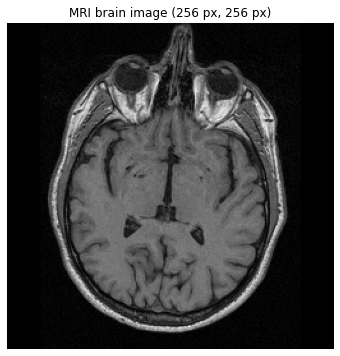

In [3]:
# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing (5pts)

First we plot the histogram of the original image and we normalize it

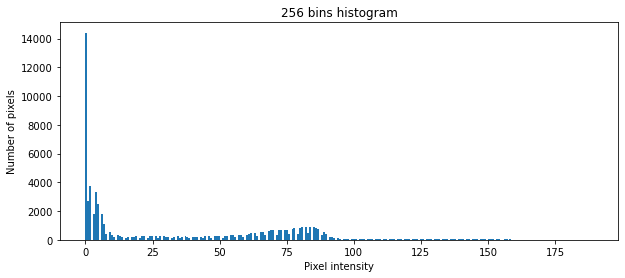

In [4]:
# Plot histogram
plt.figure(figsize=(10, 4))
plt.hist(brain_im.ravel(), bins=256)
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')
plt.title('256 bins histogram')

plt.show()

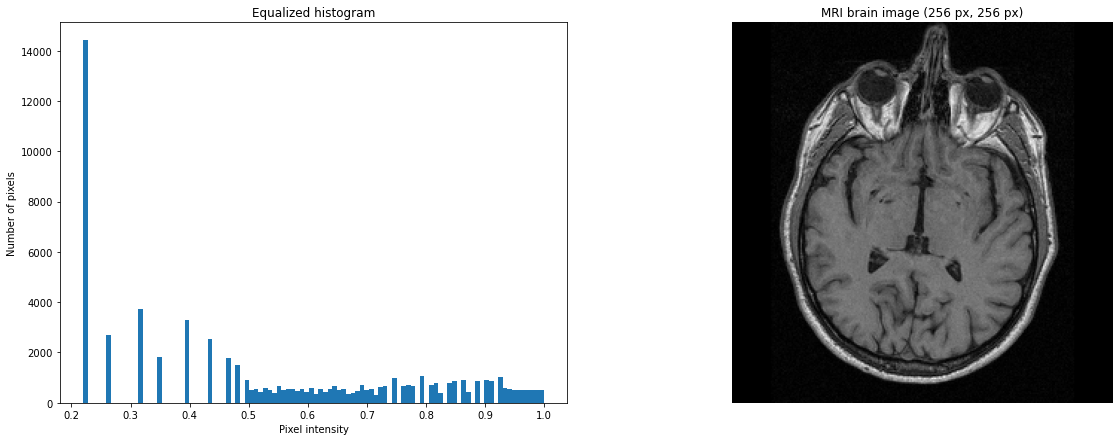

In [5]:
# Normalize histogram to enhance contrast
brain_im_eq = exposure.equalize_hist(brain_im)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.hist(brain_im_eq.ravel(), bins=100)
ax1.set_xlabel('Pixel intensity')
ax1.set_ylabel('Number of pixels')
ax1.set_title('Equalized histogram')

ax2.imshow(brain_im, cmap='gray')
ax2.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax2.axis('off')
plt.show()

Then we use a hand-picked seed that is clearly part of the brain, and we use region growing to find the connex region around it that match a homogeneity criterion. This is done by maintaining a queue of pixels "at the edge" of the growing region whose neighbours needs to be examined.

The homogeneity criterion uses two threshold: a local threshold between adjacent pixels, to avoid crossing sharp edges, and a global threshold used to avoid crossing smooth transitions by comparing the intensity of the considered pixel with the intensity of the seed.

Number of pixels in the detected region: 17230


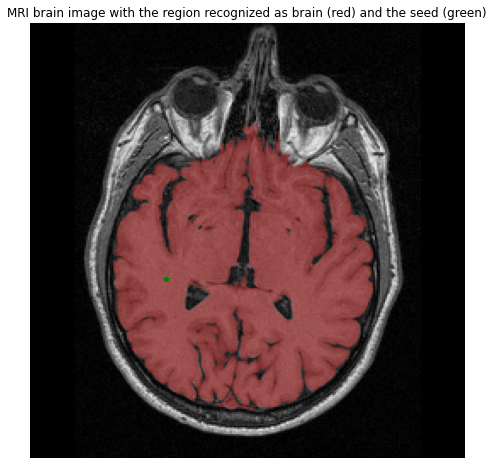

In [6]:


# Seed the detection algorithm with a point that is obviously part of the brain
seed = (150, 80)

global_threshold = 0.35
local_threshold = 0.10

# Initialize the brain region
region = np.zeros((im_h, im_w))
region[seed] = 1

# Pixels that are at the edge of the growing region
edges = deque((seed,))

# As long as edges are available
while edges:
    x, y = edges.pop()
    for dx, dy in ((1, 0), (0, 1), (-1, 0), (0, -1)):
        candidate = (x + dx, y + dy)
        if (0 <= candidate[0] < im_h and 0 <= candidate[1] < im_w
            and not region[candidate] 
            and abs(brain_im_eq[seed] - brain_im_eq[candidate]) < global_threshold 
            and abs(brain_im_eq[x, y] - brain_im_eq[candidate]) < local_threshold):
            region[candidate] = 1
            edges.append(candidate)
    
fig, ax = plt.subplots(figsize=(8,8))
cmap = matplotlib.colors.ListedColormap(['red'])
ax.imshow(brain_im, cmap='gray')
ax.imshow(np.ones(region.shape), alpha=region*0.3, cmap=cmap)
ax.plot(seed[1], seed[0], marker='*', color='green')
ax.set_title('MRI brain image with the region recognized as brain (red) and the seed (green)')
ax.axis('off')

print(f"Number of pixels in the detected region: {int(region.sum())}")

This method is quite simple, computationally inexpensive, and yields relatively good results. However, it needs a seed that is in the region to select in order to work. This can be problematic if the position of the object to detect vary significantly across the images. It also needs a calibration of the thresholds, and it is therefore sensitive to exposition variations.

### 1.3 Contour detection (5pts)

The goal of this part is to detect the contours, from this we will be able to create a binary image which will highlight the skull and will enable us to count the pixels inside the skull.

In this part we will be using the **Sobel filter for edge detection**. Note that a number of other filters could be used 

1 - 
As a first step we will apply a Gaussian filter which helps with edge detection by reducing the amount of noise and speckles in the image.

2-
We then use a sobel filter and apply it on the image. No libraries were used but results were compared to open-cv filter for testing 

3- 
Following the filter, we plot the histogram and set a threshold to get binary values

4-
We then use a morphological operator called closing that enables us to fill in holes and smoothen the contours. Note that information is "lost" 

5-
We use the OpenCV `findContours` function to find the contours of the different regions delimited by the closed edges and the area of each region is computed once again with OpenCV

6-
We select the largest region as the one of interest (obviously the brain will always be larger than the other cavities visible on the MRI image)




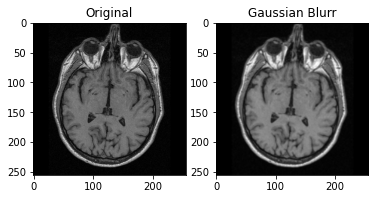

In [7]:
# Reduce noise in image
brain_im_blurr = cv2.GaussianBlur(brain_im, (3,3),0)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6, 6))
ax1.set_title('Original')
ax1.imshow(brain_im, cmap = "gray")
ax2.set_title('Gaussian Blurr')
ax2.imshow(brain_im_blurr, cmap='gray')
plt.show()

In [8]:
# Implement Sobel edge detection filter

sobel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

# Size original image
[rows, columns] = np.shape(brain_im_blurr)

# Initialize sobel filtered image to zero
sobel_brain_img = np.zeros(shape=(rows, columns))  

# Apply on image with kernel of size 3
for i in range(rows - 2):
    for j in range(columns - 2):
        # x direction
        brain_img_x = np.sum(np.multiply(sobel_x, brain_im_blurr[i:i + 3, j:j + 3]))  
        # y direction
        brain_img_y = np.sum(np.multiply(sobel_y, brain_im_blurr[i:i + 3, j:j + 3]))  
        
        sobel_brain_img[i + 1, j + 1] = np.sqrt(brain_img_x ** 2 + brain_img_y ** 2)  

The last line above is used in order to combine the horizontal and vertical convolutions.
These are two ways in which they can be combined; the first one is used. ([Source](https://docs.opencv.org/3.4/d2/d2c/tutorial_sobel_derivatives.html))
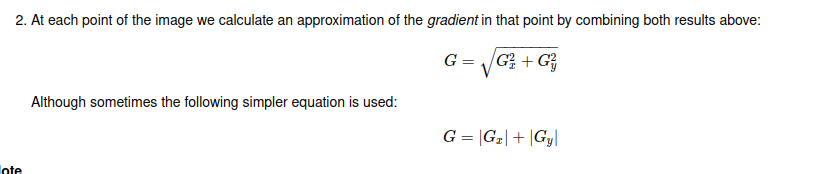

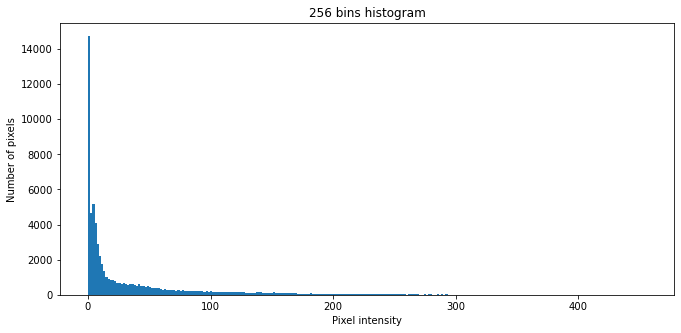

In [9]:
# Plot diagram to estimate threshold
nb_bins = 256
# Display histogram
plt.figure(figsize=(11, 5))
plt.hist(sobel_brain_img.ravel(), bins=nb_bins)
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')
plt.title('256 bins histogram')

plt.show()

In [10]:
# Set a threshold
pixel_thresh=65

_, brain_img_thresh = cv2.threshold(sobel_brain_img, pixel_thresh, 255, 0)

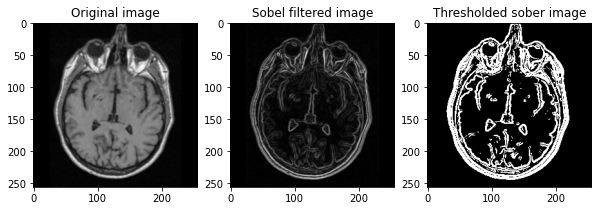

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(10, 10))

ax[0].set_title("Original image")
ax[1].set_title("Sobel filtered image")
ax[2].set_title("Thresholded sober image")
ax[0].imshow(brain_im_blurr, cmap = "gray")
ax[1].imshow(sobel_brain_img, cmap="gray")
ax[2].imshow(brain_img_thresh, cmap="gray")


In [12]:
# We use the closing morphological operator and pick the kernel size by test and trial
closing_kernel = np.ones((3,3))
brain_img_closed = cv2.morphologyEx(brain_img_thresh, cv2.MORPH_CLOSE, closing_kernel)

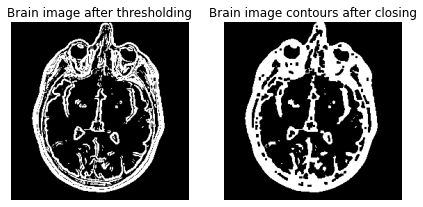

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(7, 7))
ax[0].imshow(brain_img_thresh, cmap='gray')
ax[0].set_title('Brain image after thresholding')
ax[0].axis('off')
ax[1].imshow(brain_img_closed, cmap='gray')
ax[1].set_title('Brain image contours after closing')
ax[1].axis('off')
plt.show()

In [14]:
# From float to int
brain_img_closed_int = np.uint8(brain_img_closed)
brain_contours, hierarchy = cv2.findContours(brain_img_closed_int, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

Number of pixels in the detected region: 16529.0


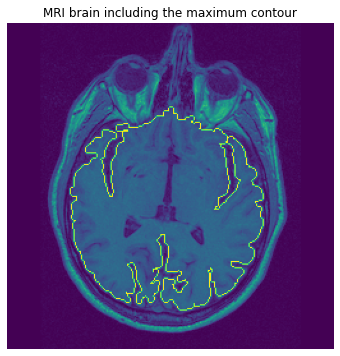

In [15]:
# Compute the areas of the found contour
# Store all areas
areas = []
for i in range(1,len(brain_contours)):
    areas.append(cv2.contourArea(brain_contours[i]))  

# Compute contour area for the largest computed area 
max_area_id = np.argmax(areas) + 1


brain_img_copy = np.copy(brain_im)

# Contoured brain
brain_contoured = cv2.drawContours(brain_img_copy, brain_contours, max_area_id, (255,255,255), 1)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_contoured)
ax.set_title("MRI brain including the maximum contour")

print(f"Number of pixels in the detected region: {np.max(areas)}")
ax.axis("off")
plt.show()

The result is comparable to the one with region growing (12730) though does appear less precise. In this case we need to set a threshold manually but also test several values for the closing kernel size.

### 1.4 Additional method (5pts)

As a additional method, we will use thresholding. The goal of this region-based segmentation method is the separation of the image into regions by setting one or several thresholds on the gray levels:

g(i,j) = 1 if f(i,j) ≥ T\
g(i,j) = 0 if f(i,j) < T 

or 

g(i,j) = 1 if f(i,j) ∈ D\
g(i,j) = 0 if f(i,j) ∉ D

Here the problem is now, how to find the optimal threshold(s). For this we will consider two approaches:

- Unsupervised thresholding (trial and error)
- Supervised thresholding (otsu technique)

### Unsupervised thresholding (trial and error)

Since we will be choosing the thresholding value ourselves, we call it supervised thresholding.
We want to find the arbitrary threshold value that best captures our desired shape of the objects.

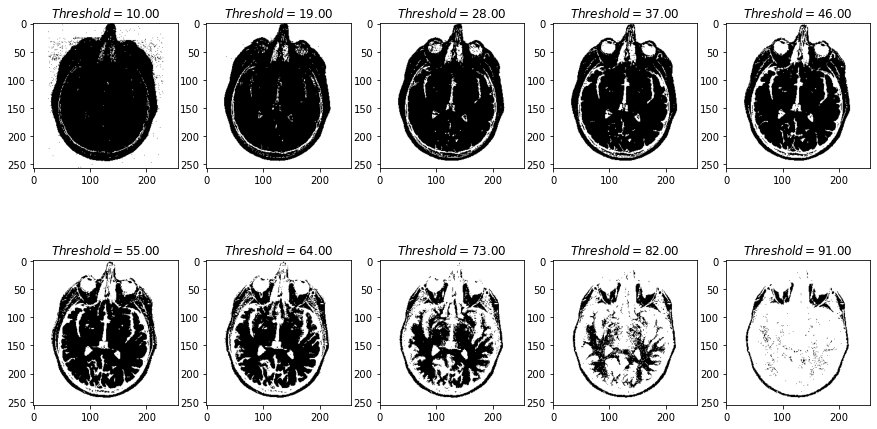

In [16]:
# Display MRI brain images with different thresholds
th_values = np.linspace(10, 100, 11)
fig, axis = plt.subplots(2, 5, figsize=(15,8))

for th, ax in zip(th_values, axis.flatten()):
    brain_binarized = brain_im < th
    ax.imshow(brain_binarized, cmap = 'gray')
    ax.set_title('$Threshold = %.2f$' % th)

From this image, we might choose a thresholding value of 37.00 to 55.00 since it captures most of the regions of the brain. However, this method is subjective. Next we will determining the thresholding automatically.

### Supervised thresholding (otsu technique)
One of the automated way to determine the threshold value is called the otsu’s method. This method assumes that the image is composed of a background and a foreground. Otsus method works by minimizing the intra-class variance or maximizing the inter-class variance.

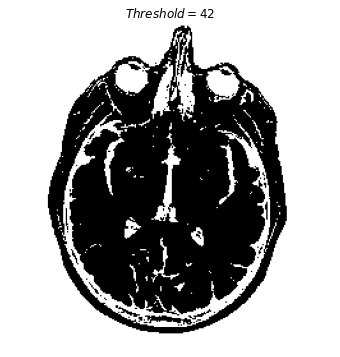

In [17]:
brain_thresh = threshold_otsu(brain_im)
brain_otsu = brain_im < brain_thresh

# Display optimal threshold of MRI brain image
fig, ax = plt.subplots(1, 1, figsize=(6,6))

ax.imshow(brain_otsu, cmap = 'gray')
ax.set_title(f'$Threshold = {brain_thresh}$')
ax.axis('off')

plt.show()

Finally we  determined the best threshold value in binarizing the image (optimal threshold: 42). This value is also within the range determined by unsupervised thresholding (trial and error). However, we should remember this method’s underlying assumption: the image is composed of a background and a foreground.


### Segmentation
After the short introduction about thresholding now we will do the segmentation to compute the size of the brain in the image.

For this, we are applying thresholding to the image:

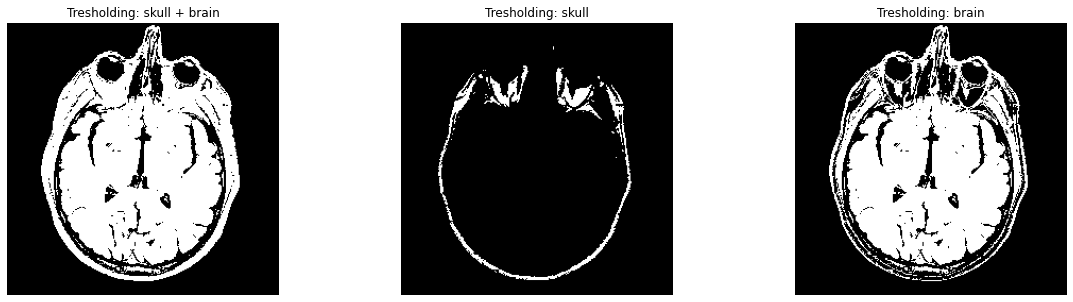

In [18]:
# Threshold to the original image
brain_thresh_im1 = threshold_otsu(brain_im)
brain_otsu_im1 = brain_im > brain_thresh_im1

# Threshold to the non-black parts of the image to distinguish the gray and white areas
brain_thresh_im2 = threshold_otsu(brain_im[brain_otsu_im1])
brain_otsu_im2 = brain_im > brain_thresh_im2

# Subtract both thresholds
brain_otsu_im3 = brain_otsu_im1 ^ brain_otsu_im2

# Display thresholded MRI brain images
fig, ax = plt.subplots(1, 3, figsize=(20,5))
    
ax[0].imshow(brain_otsu_im1, cmap='gray')
ax[0].set_title('Tresholding: skull + brain')
ax[0].axis('off')

ax[1].imshow(brain_otsu_im2, cmap='gray')
ax[1].set_title('Tresholding: skull')
ax[1].axis('off')

ax[2].imshow(brain_otsu_im3, cmap='gray')
ax[2].set_title('Tresholding: brain')
ax[2].axis('off')

plt.show()

In the first image (Tresholding: skull + brain) we can see some bright parts of the image are also considered in the threshold. 
Therefore, it would be good to apply another threshold to the non-black parts of the image to distinguish the gray and white areas. To do this, we apply the otsu algorithm once again to find the optimal threshold for the remaining part of the image (Tresholding: skull).
After this step, we can subtract the brightest parts of the image from the first threshold (Tresholding: brain).

To remove the unwanted bright/dark spots in the vicinity of the brain region some morphological methods are applied to the images. After this, the region of the brain can be computed:

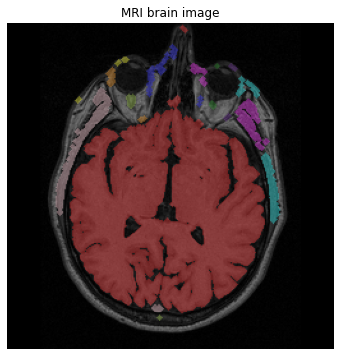

Number of pixels in the detected region: 17049


In [19]:
# Return grayscale morphological opening of MRI brain image
brain_otsu_im3_opened = opening(brain_otsu_im3, disk(2));

# Label connected regions
label_brain_im = label(brain_otsu_im3_opened)

# Overlay the resulted labels on the original image    
overlay_im = label2rgb(label_brain_im, image=brain_im) 
regions = regionprops(label_brain_im)
area=[]

# Append region to area        
for item in range(0,len(regions)):
    area.append(regions[item].area)

# Display MRI brain image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.imshow(overlay_im)
ax.set_title('MRI brain image')
ax.axis('off')

plt.show()

# Largest region in the image is the brain
print(f"Number of pixels in the detected region: {str(max(area))}")

Segmentation by thresholding is very simple and works very well. The process of thresholding involves, comparing each pixel value of the image (pixel intensity) to a specified threshold. This divides all the pixels of the input image into 2 groups: Pixels having intensity value lower or greater than the threshold. These 2 groups are given different values, depending on various segmentation types. This allows us to compute the size of a brain for example.

However, it does not define objects. With this method you only can separate background from foreground of an image.
Therefore it works in a limited number of cases, because of the fact that the foreground does not necessarily define the objects.

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different
colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity
normalization should probably be used.

hint: RGB color space might not be optimal. Consider using HSV or LAB color space.

### 2.1 Visualization

In [20]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)

reference_image = images[0]

print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


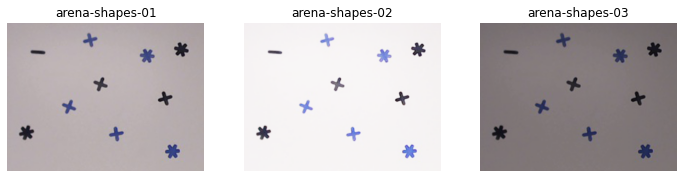

In [21]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### Exposure normalization

Before performing the segmentation, we must normalize the exposure of the pictures. To this end, we decide to use the first picture as a reference and we transform the histogram of other images to match the reference histogram. The concept is similar to the histogram equalization method that we studied in week 1, but with a non-constant target histogram. The advantage of using a non-constant target histogram is that it avoids to excessively amplify the noise on the background. This histogram transformation is implemented in `skimage.exposure.match_histograms()`.

The histogram is normalized independently in the 3 channels of each image. However, it might be interesting to normalize the histogram in another color space. So we try to normalize histograms in RGB, HSV and LAB color spaces.

Error when matching histogram in rgb space: 7.797396627145203
Error when matching histogram in hsv space: 47.36619508359912
Error when matching histogram in lab space: 7.5627427022903735


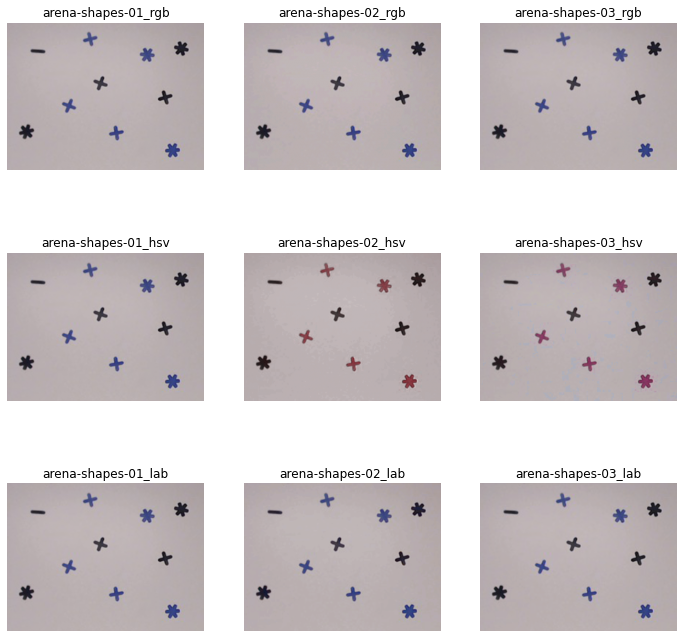

In [22]:
# Convert images to different color spaces
images_rgb = [img_as_float64(img) for img in images]
images_hsv = [rgb2hsv(img) for img in images]
images_lab = [rgb2lab(img) for img in images]

# Normalize histograms using the first image as reference
for imgs in (images_rgb, images_hsv, images_lab):
    imgs[1] = exposure.match_histograms(imgs[1], imgs[0], channel_axis=2)
    imgs[2] = exposure.match_histograms(imgs[2], imgs[0], channel_axis=2)
    
# Convert back to RGB for display
images_hsv = [hsv2rgb(img) for img in images_hsv]
images_lab = [lab2rgb(img) for img in images_lab]

# Display normalized images
fig, axes = plt.subplots(3, 3, figsize=(12,12))
for axe, imgs, color_space in zip(axes, (images_rgb, images_hsv, images_lab), ("rgb", "hsv", "lab")):
    for ax, im, name in zip(axe, imgs, im_names):
        ax.imshow(im)
        ax.axis("off")
        ax.set_title(f"{name}_{color_space}")
        
# Compute error with respect to the reference image
for imgs, color_space in zip((images_rgb, images_hsv, images_lab), ("rgb", "hsv", "lab")):
    print(f"Error when matching histogram in {color_space} space: {sum(np.linalg.norm(im - images_rgb[0]) for im in imgs)}")
        
plt.show()


We can see that the results in RGB and LAB color spaces are very good. The results in the HSV color space are less good, probably because the background noise causes the Hue component histogram to be very noisy. For the sake of simplicity, we decide to perform exposure normalization in the native RGB color space. However, the results might not be as good if some images have a different density of shapes, or a different ratio of black and blue shapes.

### Comparison of the color spaces

Segmenting colors is notably hard in the RGB space. Therefore we plot image components in the RGB, HSV and LAB color spaces in order to find which components might be useful to do the segmentation.

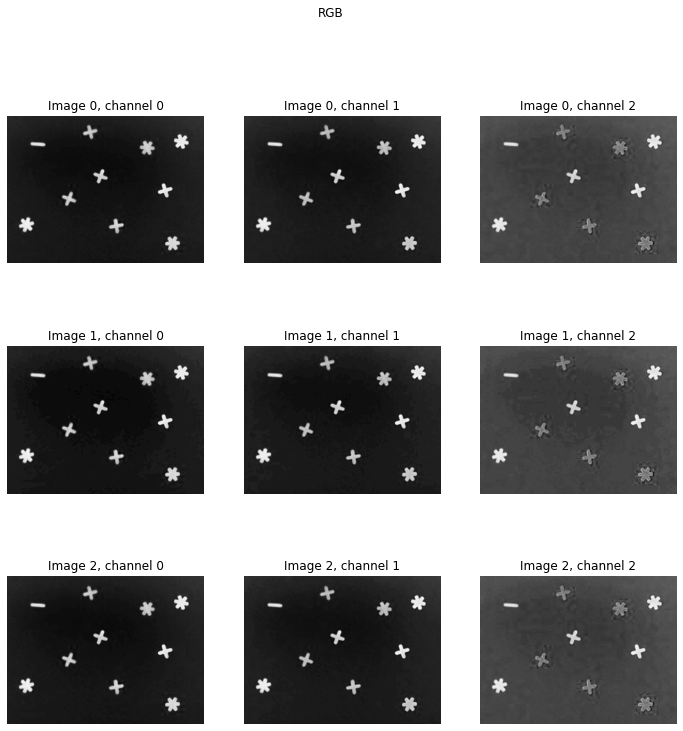

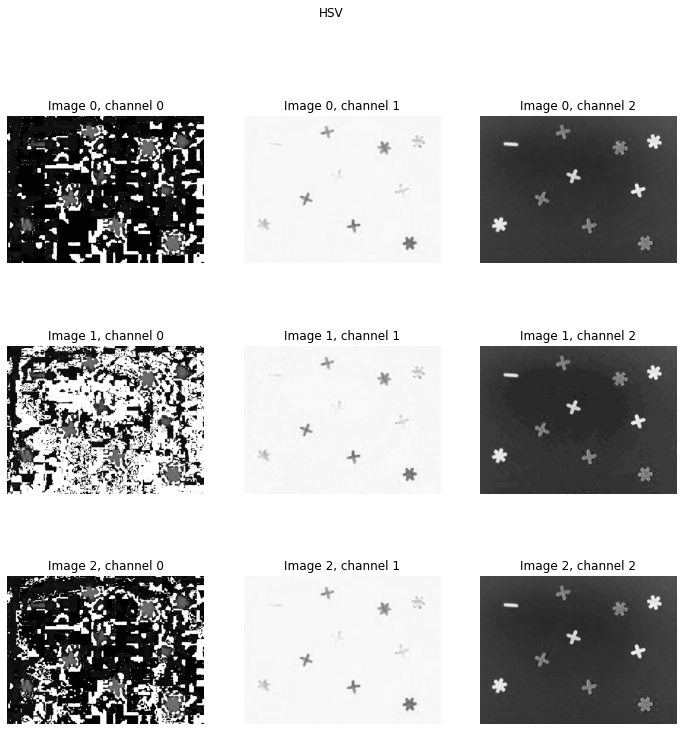

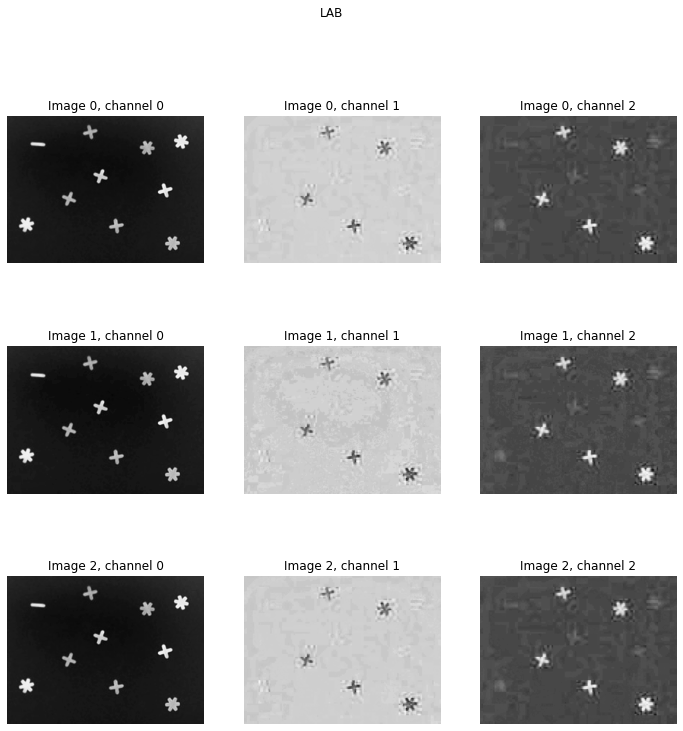

In [23]:
images_hsv = [rgb2hsv(img) for img in images_rgb]
images_lab = [rgb2lab(img) for img in images_rgb]

for imgs, name in zip((images_rgb, images_hsv, images_lab), ("RGB", "HSV", "LAB")):

    fig, axes = plt.subplots(3,3, figsize=(12,12))
    
    fig.suptitle(name)

    for axe, img, j in zip(axes, imgs, range(3)):
        for i in range(3):
            axe[i].imshow(img[:, :, i], cmap="Greys")
            axe[i].axis("off")
            axe[i].set_title(f"Image {j}, channel {i}")
            
plt.show()

We can see that the LAB color space will work well: the L channel provides a good discrimination between symbols and the background, while the A channel differentiate blue symbols. The borders of the blue symbols are not as clean as in the L channel, but it doesn't matter since we'll only use the mean of the channel 1 over the symbol area extracted on the L channel to discriminate the color of the symbol.

### 2.2 Number of shapes of each color (5 pts)

The workflow for identifying the number of shapes of each color in an image is the following:
1. Normalize the histograms to the reference values (see above for details)
1. Convert the resulting image to the LAB color space
1. Apply a threshold on the L channel to discriminate the shapes from the background. Since the histograms were normalized, the threshold should be robust to different exposure conditions.
1. Apply a morphological close operation on the result. Although this is not strictly needed, it will reduce the noise if there is some, and ensure that each shape is connex. We use an implementation from openCV: `cv2.morphologyEx`.
1. Separate the different shapes. To do this, we use the fact that each shape is connex, and different shapes are not overlapping. This mean that we just have to separate the mask obtained in the last step in connected regions. We use an optimized implementation from openCV: `cv2.connectedComponents`.
1. For each shape, we have to determine its color. Since we know which pixels are part of the shape, we can simply compute the average value of the A channel for the corresponding pixels, and use a threshold to discriminate blue from black shapes.

In [24]:
import cv2

def number_of_shapes(image):
    """Given a raw image, return the number of blue and black shapes that it contains."""
    
    # Exposure correction: match histogram of the reference image in RGB space
    global reference_image
    image = exposure.match_histograms(image, reference_image, channel_axis=2)
    
    image = rgb2lab(image) # Convert to LAB color space
    
    # Thresholding to extract the shapes from the background
    shape_mask = (image[:, :, 0] < 50).astype(np.uint8)
    
    # Closing is not strictly required, but will reject noise should there be any
    shape_mask = cv2.morphologyEx(shape_mask, cv2.MORPH_CLOSE, np.ones((3,3)))
    
    # Separate different shapes (each shape is connex and shapes are not overlapping)
    n, labels = cv2.connectedComponents(shape_mask, 8)
    
    blue, black = 0, 0
    
    for i in range(1, n):
        # Mask the pixels that are not part of the shape
        mask = labels != i
        
        # Discriminate symbol color using the mean of the A channel over the symbols area
        color_value = np.ma.array(image[:, :, 1], mask=mask).mean()
        if color_value > 8:
            blue += 1
        else:
            black += 1
    
    return (blue, black)

In [25]:
for i, img in enumerate(images):
    blue, black = number_of_shapes(img)
    print(f"Image {i}: {blue} blue symbols and {black} black symbols")

Image 0: 5 blue symbols and 5 black symbols
Image 1: 5 blue symbols and 5 black symbols
Image 2: 5 blue symbols and 5 black symbols


We can see that the shapes are correctly counted for all 3 images !

### 2.3 Total area (in pixels) of each color (5 pts)

Since we already had the pixels composing each shape in the last section, we can reuse the same method. We build a global map of the pixels belonging to shapes of each color. Then we just have to count the pixels in each map. We also return the map in order to visualize the results.

In [26]:
def area_per_color(image):
    # Exposure correction: match histogram of the reference image in RGB space
    global reference_image
    image = exposure.match_histograms(image, reference_image, channel_axis=2)
    
    image = rgb2lab(image) # Convert to LAB color space
    
    # Thresholding to extract the shapes from the background
    shape_mask = (image[:, :, 0] < 50).astype(np.uint8)
    
    # Closing is not strictly required, but will reject noise should there be any
    shape_mask = cv2.morphologyEx(shape_mask, cv2.MORPH_CLOSE, np.ones((3,3)))
    
    # Separate different shapes (each shape is connex and shapes are not overlapping)
    n, labels = cv2.connectedComponents(shape_mask, 8)
    
    # Build a global map of pixels belonging to shapes of each color
    blue_mask, black_mask = np.zeros(image.shape[:-1]), np.zeros(image.shape[:-1])
    
    for i in range(1, n):
        mask = labels == i
        color_value = np.ma.array(image[:, :, 1], mask=~mask).mean()
        if color_value > 8:
            blue_mask[mask] = 1
        else:
            black_mask[mask] = 1
    
    return (int(blue_mask.sum()), int(black_mask.sum()), blue_mask, black_mask)

Image 0: 5043 blue pixels and 5068 black pixels
Image 1: 5042 blue pixels and 5068 black pixels
Image 2: 5031 blue pixels and 5064 black pixels


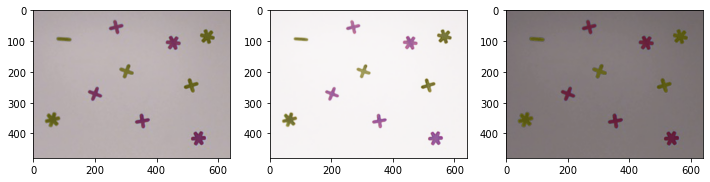

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(12, 12))

blue_cmap = matplotlib.colors.ListedColormap(['red'])
black_cmap = matplotlib.colors.ListedColormap(['yellow'])

for i, (img, ax) in enumerate(zip(images, axes)):
    blue, black, blue_mask, black_mask = area_per_color(img)
    
    print(f"Image {i}: {blue} blue pixels and {black} black pixels")
    
    ax.imshow(img)
    # Paint blue shapes in red and black shapes in yellow
    ax.imshow(np.ones(img.shape[:-1]), alpha=blue_mask*0.3, cmap=blue_cmap)
    ax.imshow(np.ones(img.shape[:-1]), alpha=black_mask*0.3, cmap=black_cmap)
    
plt.show()

We can see that all shapes are correctly recognized in all 3 images. The numbers of detected pixels in each image are also very similar, which shows that our algorithm is resistant to changes of exposure. The small differences are probably due to pixels extending over the edge of the shapes, and are therefore close to the threshold and very sensitive to exposure variations.